In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Standard Fast AI book setup**

In [2]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.13
    Uninstalling fastai-2.7.13:
      Successfully uninstalled fastai-2.7.13


In [3]:
# installing/upgrading fastai2 
!pip install --upgrade fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.9 MB/s eta 0:00:0000:0100:01


In [4]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *

**Resnets**

In [9]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [8]:
??GrandparentSplitter

Signature: GrandparentSplitter(train_name='train', valid_name='valid')
Source:   
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner
File:      /opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py
Type:      function

In [10]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

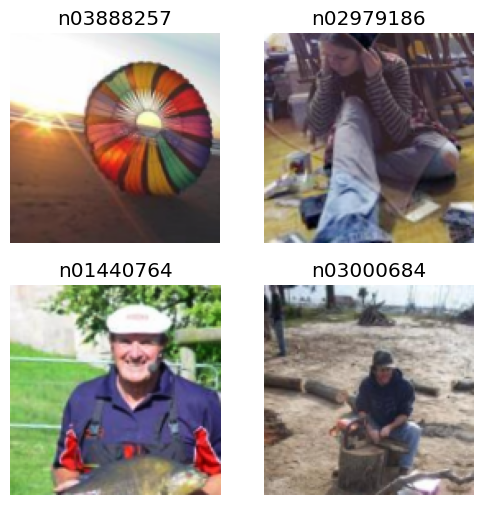

In [9]:
dls.show_batch(max_n=4)

In [11]:
def avg_pool(x): return x.mean((2,3))

In [12]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [16]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

SuggestedLRs(valley=0.0006918309954926372)

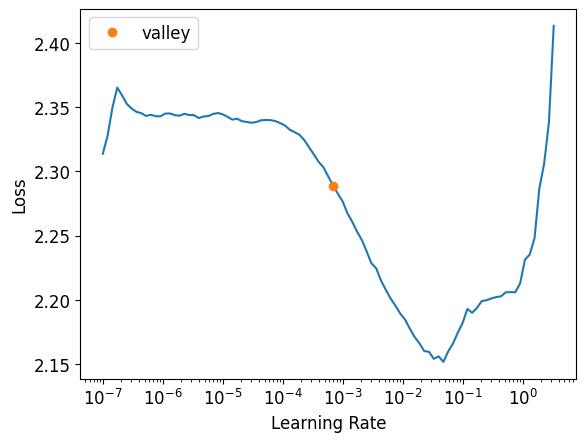

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.877264,1.959413,0.344713,00:16
1,1.530933,1.576362,0.502675,00:13
2,1.288813,1.291564,0.581911,00:13
3,1.133725,1.114230,0.647389,00:13
4,1.040491,1.060048,0.668790,00:13


In [15]:
??ImageBlock

Signature: ImageBlock(cls: 'PILBase' = <class 'fastai.vision.core.PILImage'>)
Source:   
def ImageBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
File:      /opt/conda/lib/python3.10/site-packages/fastai/vision/data.py
Type:      function

In [16]:
nn.AdaptiveAvgPool2d??

Init signature:
nn.AdaptiveAvgPool2d(
    output_size: Union[int, NoneType, Tuple[Optional[int], ...]],
) -> None
Source:        
class AdaptiveAvgPool2d(_AdaptiveAvgPoolNd):
    r"""Applies a 2D adaptive average pooling over an input signal composed of several input planes.

    The output is of size H x W, for any input size.
    The number of output features is equal to the number of input planes.

    Args:
        output_size: the target output size of the image of the form H x W.
                     Can be a tuple (H, W) or a single H for a square image H x H.
                     H and W can be either a ``int``, or ``None`` which means the size will
                     be the same as that of the input.

    Shape:
        - Input: :math:`(N, C, H_{in}, W_{in})` or :math:`(C, H_{in}, W_{in})`.
        - Output: :math:`(N, C, S_{0}, S_{1})` or :math:`(C, S_{0}, S_{1})`, where
          :math:`S=\text{output\_size}`.

    Examples:
        >>> # target output size of 5x7
        

**Building a Modern CNN: Resnet**

In [6]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero))
        
    def forward(self, x): return x + self.convs(x)

In [13]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [14]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [17]:
def block(ni,nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [18]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.958946,1.978090,0.317962,00:19
1,1.691386,1.571210,0.486879,00:17
2,1.409914,1.366966,0.564076,00:17
3,1.185498,1.075307,0.657070,00:17
4,1.058681,1.052972,0.666242,00:17


In [20]:
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [21]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.967635,1.917644,0.329682,00:18
1,1.605107,1.468261,0.506752,00:17
2,1.301569,1.282361,0.584713,00:18
3,1.064788,0.990979,0.681783,00:17
4,0.948724,0.910208,0.710573,00:17


In [22]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [23]:
#hide_output
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [24]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [26]:
rn = ResNet(dls.c, [2,2,2,2])

In [27]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.672537,2.340528,0.371210,00:15
1,1.307164,1.201135,0.621401,00:15
2,1.079338,1.005984,0.683822,00:15
3,0.874686,0.889383,0.723057,00:16
4,0.739016,0.748976,0.765096,00:18


In [29]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [30]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

In [31]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [ ]:
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.619639,1.436223,0.537580,00:58
